In [0]:
# Mount google drive to access files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Installing Pytorch Pretrained Bert i.e pretrained transformers
!pip3 install pytorch_pretrained_bert

     |████████████████████████████████| 133kB 2.8MB/s 
     |████████████████████████████████| 645kB 8.6MB/s 


In [0]:
# Installing Spacy
!pip3 install -U spacy

Requirement already up-to-date: spacy in /usr/local/lib/python3.6/dist-packages (2.2.3)


In [0]:
# Installing torch and torchvision
!pip3 install torch===1.3.1+cu100 torchvision===0.4.2 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 705.3MB 24kB/s 
  Found existing installation: torch 1.3.1
    Uninstalling torch-1.3.1:
      Successfully uninstalled torch-1.3.1


In [0]:
# Import packages
import string
import re
from tqdm import tqdm, trange
import spacy
import spacy.cli
import logging
import collections
from collections import Counter
import math

#Data Loaders and Samplers from torch
import torch
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)

#Importing Bert Models and Tokenizer
from pytorch_pretrained_bert.modeling import BertModel, BertPreTrainedModel
from pytorch_pretrained_bert.tokenization import BertTokenizer
from pytorch_pretrained_bert.optimization import BertAdam, WarmupLinearSchedule
from pytorch_pretrained_bert.tokenization import BasicTokenizer, whitespace_tokenize
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
import json
spacy.cli.download('en')  # Spacy english model

#Other imports
import random
import numpy as np
import pickle
import os
import matplotlib.pyplot as pplot

⚠ Skipping model package dependencies and setting `--no-deps`. You
don't seem to have the spaCy package itself installed (maybe because you've
built from source?), so installing the model dependencies would cause spaCy to
be downloaded, which probably isn't what you want. If the model package has
other dependencies, you'll have to install them manually.
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [0]:
# Code to install apex, which is used to accelerate training
%%writefile setup.sh

git clone https://github.com/NVIDIA/apex
pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./apex

Writing setup.sh


In [0]:
# Run setup.sh to install apex
!sh setup.sh

Cloning into 'apex'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 5566 (delta 10), reused 11 (delta 6), pack-reused 5531
Receiving objects: 100% (5566/5566), 13.36 MiB | 33.70 MiB/s, done.
Resolving deltas: 100% (3591/3591), done.
/usr/local/lib/python3.6/dist-packages/pip/_internal/commands/install.py:283: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)
Created temporary directory: /tmp/pip-ephem-wheel-cache-h_8x_5v9
Created temporary directory: /tmp/pip-req-tracker-jcv0_r80
Created requirements tracker '/tmp/pip-req-tracker-jcv0_r80'
Created temporary directory: /tmp/pip-install-neht8vfa
Processing ./apex
  Created temporary directory: /tmp/pip-req-build-gknryglx
  Added file:///content/apex to build tracker '/tmp/pip-req-tracker-jcv0_r80'
    Running setup.py (path:

In [0]:
# Importing apex optimizers
from apex.optimizers import FusedAdam
from apex.fp16_utils.fp16_optimizer import FP16_Optimizer


os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # Allocate GPU 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Set the device either cuda or cpu
n_gpu = torch.cuda.device_count() # GPU count

# random seeding
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42) 

In [0]:
# Load Bert Tokenizer
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

100%|██████████| 231508/231508 [00:00<00:00, 5677752.62B/s]


In [0]:
# Model creation using Bert Pretrained Model as a base
class CoQAwithBert(BertPreTrainedModel):

  # Configurations passed to BERT model
  def __init__(
            self,
            config,
            output_attentions=False,
            keep_multihead_output=False,
            class_alpha=1.0,
            mask_p=0.0,
    ):
    super(CoQAwithBert, self).__init__(config)
    self.class_alpha = class_alpha
    self.mask_p = mask_p
    self.bert = BertModel(
    config,
    )
    self.qa_outputs = nn.Linear(config.hidden_size, 2)
    self.output_attentions = False
    self.class_outputs = nn.Linear(config.hidden_size, 4)
    self.apply(self.init_bert_weights)
  
  # Forward pass for the BERT model
  def forward(
            self,
            input_ids,  # Input seq indices 
            token_type_ids=None,
            attention_mask=None, # Masking to avoid attention
            start_positions=None, # Starting position of the span
            end_positions=None,  # End position of the span
            class_index = None,
    ):
    outputs = self.bert(
            input_ids,
            token_type_ids,
            attention_mask,
            output_all_encoded_layers=False,
        )
    
    # outputs consists of the elements based on the configurations provided to BERT
    sequence_output, class_outputs = outputs 
    span_logits = self.qa_outputs(sequence_output)
    class_logits = self.class_outputs(class_outputs)
    start_logits, end_logits = span_logits.split(1, dim=-1)
    start_logits = start_logits.squeeze(-1)
    end_logits = end_logits.squeeze(-1)

    # Span extraction based on start positions and end positions
    if start_positions is not None and end_positions is not None:
      if len(start_positions.size()) > 1:
        start_positions = start_positions.squeeze(-1)
      if len(end_positions.size()) > 1:
        end_positions = end_positions.squeeze(-1)
      ignored_index = start_logits.size(1)
      start_positions.clamp_(0, ignored_index)
      end_positions.clamp_(0, ignored_index)

      span_loss_factor = CrossEntropyLoss(ignore_index=ignored_index)
      class_loss_factor = CrossEntropyLoss()
      start_loss = span_loss_factor(start_logits, start_positions)
      end_loss = span_loss_factor(end_logits, end_positions)
      class_loss = class_loss_factor(class_logits, class_index)
      total_loss = (start_loss + end_loss) / 2 + self.class_alpha * class_loss
      return total_loss
    return start_logits, end_logits, class_logits   

In [0]:
# Load the model
model = CoQAwithBert.from_pretrained('bert-base-uncased', mask_p=0)

100%|██████████| 407873900/407873900 [00:04<00:00, 85904521.03B/s]


In [0]:
# Set model for half precision
model.half()

CoQAwithBert(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
      

In [0]:
# Set device type for model
model.to(device)

CoQAwithBert(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
      

In [0]:
#Class to store questions, their answers along with the starting index of the answer and end index of answer and tokens in the story
class QA(object):
  def __init__(
            self,
            question_answer_id,
            question_text,
            document_tokens,
            original_answer_text=None,
            answer_start_position=None,
            answer_end_position=None,
            additional_answers=None,
    ):
    self.question_answer_id = question_answer_id
    self.question_text = question_text
    self.document_tokens = document_tokens
    self.original_answer_text = original_answer_text
    self.answer_start_position = answer_start_position
    self.answer_end_position = answer_end_position
    self.additional_answers = additional_answers

In [0]:
# Class to store features, input ids, input mask, segment ids, start positions, end positions, etc
class DataFeatures(object):
  def __init__(self,
                 unique_id,
                 example_index,
                 document_span_index,
                 tokens,
                 token_to_origin_mapping,
                 token_max_context,
                 input_ids,
                 input_mask,
                 segments,
                 start_position=None,
                 end_position=None,
                 class_index=None):            
    self.unique_id = unique_id
    self.example_index = example_index
    self.document_span_index = document_span_index
    self.tokens = tokens
    self.token_to_origin_mapping = token_to_origin_mapping
    self.token_max_context = token_max_context
    self.input_ids = input_ids
    self.input_mask = input_mask
    self.segments = segments
    self.start_position = start_position
    self.end_position = end_position
    self.class_index = class_index

In [0]:
# Function to read COQA datasets and process the data
def get_data_from_coqa(isTrain, input_file, history_len=2, add_QA_tag=False):

# Check if the character is a white space
  def check_whitespace(char):
        if char == " " or char == "\t" or char == "\r" or char == "\n" or ord(char) == 0x202F:
            return True
        return False

# Token conversion
  def tokenize_string(str):
        if (str.lower() == '-lrb-'):
            str = '('
        elif (str.lower() == '-rrb-'):
            str = ')'
        elif (str.lower() == '-lsb-'):
            str = '['
        elif (str.lower() == '-rsb-'):
            str = ']'
        elif (str.lower() == '-lcb-'):
            str = '{'
        elif (str.lower() == '-rcb-'):
            str = '}'
        return str

  def space_extension(matchobject):
    return ' ' + matchobject.group(0) + ' '  

 # Preprocessing 
  def pre_processing(word):
    word = re.sub(
        u'-|\u2010|\u2011|\u2012|\u2013|\u2014|\u2015|%|\[|\]|:|\(|\)|/|\t',
        space_extension, word)
    word = word.strip(' \n')
    word = re.sub('\s+', ' ', word)
    return word

  # Process text to return output as words with their indexes in the sentences 
  def processing(main_text):
          processed_text = {'word': [], 'offsets': [], 'sentences': []}

          for token in main_text:
              processed_text['word'].append(tokenize_string(token.text))
              processed_text['offsets'].append((token.idx, token.idx + len(token.text)))

          word_index = 0
          for sentence in main_text.sents:
              processed_text['sentences'].append((word_index, word_index + len(sentence)))
              word_index += len(sentence)

          assert word_index == len(processed_text['word'])
          return processed_text

  # Get the context offsets
  def context_offsets(words, raw_text):
    raw_text_context_offsets = []
    r = 0
    for token in words:
        while r < len(raw_text) and re.match('\s', raw_text[r]):
            r += 1
        if raw_text[r:r + len(token)] != token:
            print('Error', token, 'Raw Text:', raw_text)

        raw_text_context_offsets.append((r, r + len(token)))
        r += len(token)

    return raw_text_context_offsets

  # Function to find span with start and end index provided
  def define_span_indices(offsets, start_pos, end_pos):
    span_start_index = -1
    span_end_index = -1
    for i, offset in enumerate(offsets):
        if (span_start_index < 0) or (start_pos >= offset[0]):
            span_start_index = i
        if (span_end_index < 0) and (end_pos <= offset[1]):
            span_end_index = i
    return (span_start_index, span_end_index)

# Removing punctuations, lowering texts and removing extra white spaces
  def pre_process_answer(s):
    
    # Remove articles from the text
    def remove_articles(text):
        reg_expression = re.compile(r'\b(a|an|the)\b', re.UNICODE)
        return re.sub(reg_expression, ' ', text)
    
    # Remove white spaces from the text
    def adjust_white_space(text):
        return ' '.join(text.split())

    # Remove punctuations from the text
    def remove_punctuations(text):
        rem = set(string.punctuation)
        return ''.join(c for c in text if c not in rem)

    # Lower the text characters
    def lowering_text(text):
        return text.lower()

    return adjust_white_space(remove_articles(remove_punctuations(lowering_text(s))))  

# Find the span providing the context and offsets  
  def span_with_ground_truth(context, offsets, ground_truth):
    best_F1 = 0.0
    best_span = (len(offsets) - 1, len(offsets) - 1)
    ground_truth_temp = pre_process_answer(pre_processing(ground_truth)).split()

    ls = [
        i for i in range(len(offsets))
        if context[offsets[i][0]:offsets[i][1]].lower() in ground_truth
    ]

    for i in range(len(ls)):
        for j in range(i, len(ls)):
            prediction = pre_process_answer(
                pre_processing(
                    context[offsets[ls[i]][0]:offsets[ls[j]][1]])).split()
            common = Counter(prediction) & Counter(ground_truth_temp)
            num_same = sum(common.values())
            if num_same > 0:
                precision = 1.0 * num_same / len(prediction)
                recall = 1.0 * num_same / len(ground_truth_temp)
                F1 = (2 * precision * recall) / (precision + recall)
                if F1 > best_F1:
                    best_F1 = F1
                    best_span = (ls[i], ls[j])
    return best_span

  nlp = spacy.load('en', parser=False) 
  # Read training file
  with open(input_file, "r", encoding='utf-8') as reader:
        input_text_file = json.load(reader)["data"]
  samples = []
  input_text_file = input_text_file 

  if isTrain:
    data_len = 1000  # Restricted training data due to hardware limitations
  else:
    data_len = len(input_text_file) # Entire Development Data is loaded 

  # Fetch and store story, questions and answers after processing the text
  for data_index in tqdm(range(data_len), desc='Generating examples'):
    input_data = input_text_file[data_index]
    context_string = input_data['story']
    input_data_object = {
        'context': context_string,
        'source': input_data['source'],
        'id': input_data['id'],
        'filename': input_data['filename']
    }
    nlp_context = nlp(pre_processing(context_string)) 
    input_data_object['annotated_context'] = processing(nlp_context)
    input_data_object['raw_context_offsets'] = context_offsets(
          input_data_object['annotated_context']['word'], context_string)  
    assert len(input_data['questions']) == len(input_data['answers'])
    additional_answers = {} 
    if 'additional_answers' in input_data:
      for k, answer in input_data['additional_answers'].items():
        if len(answer) == len(input_data['answers']):
          for example in answer:
            index = example['turn_id']
            if index not in additional_answers:
              additional_answers[index] = []
            additional_answers[index].append(example['input_text'])
    for i in range(len(input_data['questions'])):
      question, answer = input_data['questions'][i], input_data['answers'][i]
      assert question['turn_id'] == answer['turn_id']

      index = question['turn_id']
      _qas = {
          'turn_id': index,
          'question': question['input_text'],
          'answer': answer['input_text']
      }

      if index in additional_answers:
        _qas['additional_answers'] = additional_answers[index]
      _qas['raw_answer'] = answer['input_text']

      if _qas['raw_answer'].lower() in ['yes', 'yes.']:
        _qas['raw_answer'] = 'yes'
      if _qas['raw_answer'].lower() in ['no', 'no.']:
        _qas['raw_answer'] = 'no'
      if _qas['raw_answer'].lower() in ['unknown', 'unknown.']:
        _qas['raw_answer'] = 'unknown'       
      _qas['answer_span_start'] = answer['span_start']
      _qas['answer_span_end'] = answer['span_end']
      start = answer['span_start']
      end = answer['span_end']
      chosen_text = input_data_object['context'][start:end].lower()
      while len(chosen_text) > 0 and check_whitespace(chosen_text[0]):
        chosen_text = chosen_text[1:]
        start += 1
      while len(chosen_text) > 0 and check_whitespace(chosen_text[-1]):
        chosen_text = chosen_text[:-1]
        end -= 1
      input_text = _qas['answer'].strip().lower()
      if input_text in chosen_text:
        p = chosen_text.find(input_text)
        _qas['answer_span'] = define_span_indices(input_data_object['raw_context_offsets'],
                                                start + p,
                                                start + p + len(input_text))
      else:
        _qas['answer_span'] = span_with_ground_truth(
                    input_data_object['context'], input_data_object['raw_context_offsets'],
                    input_text)
        long_question = ''
        for j in range(i - history_len, i + 1):
           if j < 0:
             continue
           long_question += (' <Q> ' if add_QA_tag else
                                  ' ') + input_data['questions'][j]['input_text']
           if j < i:
                    long_question += (' <A> ' if add_QA_tag else
                                      ' ') + input_data['answers'][j]['input_text']
           long_question = long_question.strip()
           _qas['raw_long_question'] = long_question
           _qas['annotated_long_question'] = processing(
                nlp(pre_processing(long_question)))
   
   # Store questions along with their answers     
           sample = QA(
                question_answer_id =input_data_object['id'] + ' ' + str(_qas['turn_id']),
                question_text =_qas['raw_long_question'],
                document_tokens =input_data_object['annotated_context']['word'],
                original_answer_text =_qas['raw_answer'],
                answer_start_position =_qas['answer_span'][0],
                answer_end_position =_qas['answer_span'][1],
                additional_answers=_qas['additional_answers'] if 'additional_answers' in _qas else None,
                )
           samples.append(sample)

  return samples

In [0]:
# Read CoQA training file, Needs to provide the training file path here
training_samples = get_data_from_coqa(True, input_file="/content/drive/My Drive/coqa-train-v1.0.json", history_len= 2, add_QA_tag= False)
print(training_samples)

Generating examples: 100%|██████████| 1000/1000 [06:52<00:00,  2.39it/s]

[<__main__.QA object at 0x7fa32957a668>, <__main__.QA object at 0x7fa32957a400>, <__main__.QA object at 0x7fa32957a278>, <__main__.QA object at 0x7fa32957a940>, <__main__.QA object at 0x7fa32957acf8>, <__main__.QA object at 0x7fa32957a160>, <__main__.QA object at 0x7fa32957a4e0>, <__main__.QA object at 0x7fa32957aba8>, <__main__.QA object at 0x7fa32957ab70>, <__main__.QA object at 0x7fa32957a898>, <__main__.QA object at 0x7fa32957a5f8>, <__main__.QA object at 0x7fa32957ad30>, <__main__.QA object at 0x7fa32957a4a8>, <__main__.QA object at 0x7fa32957ac50>, <__main__.QA object at 0x7fa32957a860>, <__main__.QA object at 0x7fa32957ac18>, <__main__.QA object at 0x7fa32957a7f0>, <__main__.QA object at 0x7fa32957ac88>, <__main__.QA object at 0x7fa32957a8d0>, <__main__.QA object at 0x7fa32957a470>, <__main__.QA object at 0x7fa32957a748>, <__main__.QA object at 0x7fa32957a6a0>, <__main__.QA object at 0x7fa32957a9e8>, <__main__.QA object at 0x7fa32957a198>, <__main__.QA object at 0x7fa32957aef0>,

In [0]:
# Function to improve the answer by modifying the start and end indexes to appropriate answer
def modify_answer_span(document_tokens, input_start_index, input_end_index, tokenizer, original_answer_text):
  token_answer_text = " ".join(bert_tokenizer.tokenize(original_answer_text))
  
  # loop to modify the indexes for appropriate answer
  for new_start_index in range(input_start_index, input_end_index + 1):
    for new_end_index in range(input_end_index, new_start_index - 1, -1):
      text_span = " ".join(document_tokens[new_start_index:(new_end_index + 1)])
      if text_span == token_answer_text:
        return (new_start_index, new_end_index)
  return (input_start_index, input_end_index)

In [0]:
# Function to select the span with the maximum context for the token
def check_max_context(document_spans, current_span_index, current_position):
  best_score = None
  best_span_index = None
  for (span_index, document_span) in enumerate(document_spans):
    end = document_span.start + document_span.length - 1
    if current_position < document_span.start:
            continue
    if current_position > end:
            continue
    left_context = current_position - document_span.start
    right_context = end - current_position
    score = min(left_context, right_context) + 0.01 * document_span.length # Score calculation for the current start and end index
    if best_score is None or score > best_score:  # selection of indexes based on better score
      best_score = score
      best_span_index = span_index
  
  return current_span_index == best_span_index

In [0]:
# Function to convert CoQA Data to features
def converting_examples_into_features(examples, tokenizer, maximum_sequence_length, document_stride, maximum_query_length):
  unique_id = 1000000000
  features = []
  for (example_index, example) in enumerate(tqdm(examples, desc="Generating features for CoQA...")):
    query_token = tokenizer.tokenize(example.question_text)
    class_index = 3

    # Check for the type of answer whether it is yes/no type otherwise set to unknown
    if example.original_answer_text == 'yes':
      class_index = 0  
    elif example.original_answer_text == 'no':
      class_index = 1 
    elif example.original_answer_text == 'unknown':
      class_index = 2  
  
    # Check for the length of the query and select the query until uth maximum query length set
    if len(query_token) > maximum_query_length:
      query_token = query_token[0:maximum_query_length]
    
    token_to_original_index = []
    original_to_token_index = []
    all_document_tokens = []

    for (i, token) in enumerate(example.document_tokens):
      original_to_token_index.append(len(all_document_tokens))
      sub_tokens = tokenizer.tokenize(token)
      for sub_token in sub_tokens:
        token_to_original_index.append(i)
        all_document_tokens.append(sub_token)
    
    token_start_position = None
    token_end_position = None
    if class_index < 3:
      token_start_position, token_end_position = 0,0
    else:
      token_start_position = original_to_token_index[example.answer_start_position]
      if example.answer_end_position < len(example.document_tokens) - 1:
        token_end_position = original_to_token_index[example.answer_end_position + 1] - 1
      else:
        token_end_position = len(all_document_tokens) - 1
      (token_start_position, token_end_position) = modify_answer_span(
                all_document_tokens, token_start_position, token_end_position, tokenizer,
                example.original_answer_text)
      
    maximum_tokens_for_document = maximum_sequence_length - len(query_token) - 3
    _DocSpan = collections.namedtuple(  
            "DocSpan", ["start", "length"])
    document_spans = []
    start_offset = 0
    while start_offset < len(all_document_tokens):
      length = len(all_document_tokens) - start_offset
      if length > maximum_tokens_for_document:
        length = maximum_tokens_for_document
      document_spans.append(_DocSpan(start=start_offset, length=length))
      if start_offset + length == len(all_document_tokens):
        break
      start_offset += min(length, document_stride)
    
    # loop to add the seperator tokens in the input sequence
    for (document_span_index, document_span) in enumerate(document_spans):      
      slice_class_index = class_index
      tokens = []
      token_to_origin_mapping = {}
      token_max_context = {}
      segment_ids = []
      tokens.append("[CLS]")
      segment_ids.append(0)
      for token in query_token:
          tokens.append(token)
          segment_ids.append(0)
      tokens.append("[SEP]")
      segment_ids.append(0)

      for i in range(document_span.length):
        split_token_index = document_span.start + i
        token_to_origin_mapping[len(
                    tokens)] = token_to_original_index[split_token_index]
        is_max_context = check_max_context(document_spans,
                                                       document_span_index,
                                                       split_token_index)
        token_max_context[len(tokens)] = is_max_context
        tokens.append(all_document_tokens[split_token_index])
        segment_ids.append(1)
      tokens.append("[SEP]")
      segment_ids.append(1)
      input_ids = tokenizer.convert_tokens_to_ids(tokens)

      input_mask = [1] * len(input_ids)

      while len(input_ids) < maximum_sequence_length:
        input_ids.append(0)
        input_mask.append(0)
        segment_ids.append(0)
      
      assert len(input_ids) == maximum_sequence_length
      assert len(input_mask) == maximum_sequence_length
      assert len(segment_ids) == maximum_sequence_length

      # Start and end position calculations
      start_position = None
      end_position = None
      if class_index >= 3:
        document_start = document_span.start
        document_end = document_span.start + document_span.length - 1
        out_of_span = False
        if not (token_start_position >= document_start
                        and token_end_position <= document_end):
          out_of_span = True
        if out_of_span:
          start_position = 0
          end_position = 0
          slice_class_index = 2
        else:
          document_offset = len(query_token) + 2
          start_position = token_start_position - document_start + document_offset
          end_position = token_end_position - document_start + document_offset
      else:
        start_position = 0
        end_position = 0

      # add the current feature calculated to the features list   
      features.append(                            
          DataFeatures(unique_id=unique_id,
                        example_index=example_index,
                        document_span_index=document_span_index,
                        tokens=tokens,
                        token_to_origin_mapping=token_to_origin_mapping,
                        token_max_context=token_max_context,
                        input_ids=input_ids,
                        input_mask=input_mask,
                        segments=segment_ids,
                        start_position=start_position,
                        end_position=end_position,
                        class_index=slice_class_index))
      
      unique_id += 1

  return features  # Return all the features

In [0]:
# Convert training data to features
training_data_features = converting_examples_into_features(
                examples=training_samples,
                tokenizer=bert_tokenizer,
                maximum_sequence_length=450,
                document_stride=150,
                maximum_query_length=75,
            )

Generating features for CoQA...: 100%|██████████| 15624/15624 [01:30<00:00, 173.18it/s]


In [0]:
# Tensor construction for input ids
dataset_input_ids = torch.tensor([f.input_ids for f in training_data_features], dtype=torch.long)
print(dataset_input_ids)

# Tensor construction for input masks
dataset_input_masks = torch.tensor([f.input_mask for f in training_data_features], dtype=torch.long)
print(dataset_input_masks)

# Tensor construction for segment ids
dataset_segment_ids = torch.tensor([f.segments for f in training_data_features], dtype=torch.long)
print(dataset_segment_ids)

#Tensor construction for start positions
dataset_start_positions = torch.tensor([f.start_position for f in training_data_features], dtype=torch.long)
print(dataset_start_positions)

#Tensor construction for end positions
dataset_end_positions = torch.tensor([f.end_position for f in training_data_features], dtype=torch.long)
print(dataset_end_positions)

dataset_class_index = torch.tensor([f.class_index for f in training_data_features], dtype=torch.long)

# Wrapping tensors in a tensor dataset
training_data = TensorDataset(dataset_input_ids, dataset_input_masks, dataset_segment_ids, dataset_start_positions, dataset_end_positions,dataset_class_index)
print(training_data)

# Train sampler to return random indices
training_data_sampler = RandomSampler(training_data)
print(training_data_sampler)

# Creating python iterable over tensor datasets
training_dataloader = DataLoader(training_data, sampler=training_data_sampler, batch_size=8)
print(training_dataloader)

tensor([[ 101, 2043, 2001,  ...,    0,    0,    0],
        [ 101, 2043, 2001,  ...,    0,    0,    0],
        [ 101, 2043, 2001,  ...,    0,    0,    0],
        ...,
        [ 101, 2339, 1029,  ...,    0,    0,    0],
        [ 101, 2339, 1029,  ...,    0,    0,    0],
        [ 101, 2339, 1029,  ...,    0,    0,    0]])
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])
tensor([ 42, 122, 129,  ...,   0,   0,   0])
tensor([ 49, 124, 131,  ...,   0,   0,   0])


In [0]:
# Assigning names to the elements of tuples
RawResult = collections.namedtuple("RawResult",
                                   ["unique_id", "start_logits", "end_logits", "cls_logits"])

In [0]:
# Calculation for optimization steps accordingly training length, which will be used for learning rate for BERT model
train_optimization_steps = len(
            training_dataloader
        ) 

In [0]:
# Fetch the training hyperparameters
parameter_optimizer = list(model.named_parameters())
parameter_optimizer = [n for n in parameter_optimizer if 'pooler' not in n[0]]
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in parameter_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in parameter_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}]


In [0]:
# Load apex optimizers
optimizer = FusedAdam(optimizer_grouped_parameters,
                                  lr=5e-5,
                                  bias_correction=False)
optimizer = FP16_Optimizer(optimizer, dynamic_loss_scale=True)

FP16_Optimizer processing param group 0:
FP16_Optimizer received torch.cuda.HalfTensor with torch.Size([30522, 768])
FP16_Optimizer received torch.cuda.HalfTensor with torch.Size([512, 768])
FP16_Optimizer received torch.cuda.HalfTensor with torch.Size([2, 768])
FP16_Optimizer received torch.cuda.HalfTensor with torch.Size([768, 768])
FP16_Optimizer received torch.cuda.HalfTensor with torch.Size([768, 768])
FP16_Optimizer received torch.cuda.HalfTensor with torch.Size([768, 768])
FP16_Optimizer received torch.cuda.HalfTensor with torch.Size([768, 768])
FP16_Optimizer received torch.cuda.HalfTensor with torch.Size([3072, 768])
FP16_Optimizer received torch.cuda.HalfTensor with torch.Size([768, 3072])
FP16_Optimizer received torch.cuda.HalfTensor with torch.Size([768, 768])
FP16_Optimizer received torch.cuda.HalfTensor with torch.Size([768, 768])
FP16_Optimizer received torch.cuda.HalfTensor with torch.Size([768, 768])
FP16_Optimizer received torch.cuda.HalfTensor with torch.Size([768, 7

In [0]:
# Learning rate for BERT model
warmup_linear = WarmupLinearSchedule(
                warmup=0.1,
                t_total=train_optimization_steps)

In [0]:
global_step = 0 # Global step initialized, will be incremented and used in training the model

In [0]:
# Set model in training mode
model.train()

CoQAwithBert(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
      

In [0]:
# Train the model with training data
# Accuracy and loss for plotting
plot_data = []
for epoch in trange(3, desc="Epoch"): # Epoch provided: 3, restricted for now to avoid the memory issue but can be increased to improve the model
  for step, batch in enumerate(
          tqdm(training_dataloader,
                desc="Iteration",
                disable=-1 not in [-1, 0])):
    if n_gpu == 1: # check for gpu count 
          batch = tuple(
              t.to(device)
              for t in batch)
    # Get the batch data to be provided to the model
    dataset_input_ids,dataset_input_masks,dataset_segment_ids, dataset_start_positions, dataset_end_positions, dataset_class_index = batch
    loss = model(dataset_input_ids, dataset_segment_ids, dataset_input_masks,
                    dataset_start_positions, dataset_end_positions, dataset_class_index)
    plot_data.append(loss.item()) # Adding the loss to plot data to plot the graph in the end 
    optimizer.backward(loss)         
    if (step + 1) % 1 == 0:
      lr_this_step = 5e-5 * warmup_linear.get_lr(global_step , 0.1)
      for param_group in optimizer.param_groups:
        param_group['lr'] = lr_this_step
    optimizer.step()
    optimizer.zero_grad()
    global_step += 1

Iteration:   0%|          | 1/2208 [00:00<15:04,  2.44it/s]

Gradient overflow.  Skipping step, reducing loss scale to 32768.0



Iteration:   0%|          | 2/2208 [00:00<14:45,  2.49it/s]

Gradient overflow.  Skipping step, reducing loss scale to 16384.0



Iteration:   0%|          | 3/2208 [00:01<14:30,  2.53it/s]

Gradient overflow.  Skipping step, reducing loss scale to 8192.0



Iteration:   0%|          | 5/2208 [00:01<14:16,  2.57it/s]

Gradient overflow.  Skipping step, reducing loss scale to 4096.0



Iteration:   0%|          | 8/2208 [00:03<14:06,  2.60it/s]

Gradient overflow.  Skipping step, reducing loss scale to 2048.0



Iteration:   2%|▏         | 38/2208 [00:14<13:53,  2.60it/s]

Gradient overflow.  Skipping step, reducing loss scale to 1024.0



Iteration:   5%|▌         | 116/2208 [00:44<13:23,  2.60it/s]

Gradient overflow.  Skipping step, reducing loss scale to 512.0



Iteration:   5%|▌         | 118/2208 [00:45<13:20,  2.61it/s]

Gradient overflow.  Skipping step, reducing loss scale to 256.0



Iteration:  14%|█▍        | 315/2208 [02:01<12:07,  2.60it/s]

Gradient overflow.  Skipping step, reducing loss scale to 128.0



Iteration:  20%|█▉        | 437/2208 [02:47<11:20,  2.60it/s]

Gradient overflow.  Skipping step, reducing loss scale to 64.0



Iteration:  58%|█████▊    | 1278/2208 [08:11<05:57,  2.60it/s]

Gradient overflow.  Skipping step, reducing loss scale to 64.0



Iteration:  86%|████████▋ | 1908/2208 [12:13<01:55,  2.60it/s]

Gradient overflow.  Skipping step, reducing loss scale to 32.0



Epoch: 100%|██████████| 3/3 [42:26<00:00, 848.70s/it]


In [0]:
# Output directory to store predictions 
output_directory = '/content/drive/My Drive/Outputs/predictions'

In [0]:
# If output directory doesn't exist create one
if not os.path.exists(output_directory):
  os.makedirs(output_directory)

In [0]:
# Set device to model either cpu or gpu
model.to(device)

CoQAwithBert(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
      

In [0]:
# Read COQA Dev file, File path needs to be provided where COQA dev file is stored
testing_samples = get_data_from_coqa(False, input_file="/content/drive/My Drive/coqa-dev-v1.0.json",
                                                history_len= 2,
                                                add_QA_tag= False)

Generating examples: 100%|██████████| 500/500 [03:44<00:00,  3.22it/s]


In [0]:
# Converting the development examples to features
testing_features = converting_examples_into_features(
                examples=testing_samples,
                tokenizer=bert_tokenizer,
                maximum_sequence_length=450,
                document_stride=150,
                maximum_query_length=75,
            )
print(testing_features[0])

Generating features for CoQA...: 100%|██████████| 8650/8650 [00:47<00:00, 181.75it/s]

In [0]:
#Tensor construction for input ids
dataset_input_ids = torch.tensor([f.input_ids for f in testing_features], dtype=torch.long)
print(dataset_input_ids)

#Tensor construction for input masks
dataset_input_masks = torch.tensor([f.input_mask for f in testing_features], dtype=torch.long)
print(dataset_input_masks)

#Tensor construction for segment ids
dataset_segment_ids = torch.tensor([f.segments for f in testing_features], dtype=torch.long)
print(dataset_segment_ids)

dataset_example_index  = torch.arange(dataset_input_ids.size(0), dtype=torch.long)

# Wrapping tensors in a tensor dataset
testing_data = TensorDataset(dataset_input_ids, dataset_input_masks, dataset_segment_ids, dataset_example_index)
print(testing_data)

# Sampling the elements in the same order they are(sequentially)
testing_data_sampler = SequentialSampler(testing_data)
print(testing_data_sampler)

# Creating python iterable over tensor dataset
testing_dataloader = DataLoader(testing_data, sampler=testing_data_sampler, batch_size=8)
print(testing_dataloader)

tensor([[ 101, 2054, 3609,  ...,    0,    0,    0],
        [ 101, 2054, 3609,  ...,    0,    0,    0],
        [ 101, 2054, 3609,  ...,    0,    0,    0],
        ...,
        [ 101, 2003, 2009,  ...,    0,    0,    0],
        [ 101, 2003, 2009,  ...,    0,    0,    0],
        [ 101, 2003, 2009,  ...,    0,    0,    0]])
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])


In [0]:
# Set model in evaluation mode
model.eval()

CoQAwithBert(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
      

In [0]:
# Fetch the results for predictions using the trained model
results_for_predictions = []
for tqdm_input_ids, tqdm_input_mask, tqdm_segment_ids, tqdm_example_indices in tqdm(
                testing_dataloader,
                desc="Evaluation",
                disable=-1 not in [-1, 0]):
  tqdm_input_ids = tqdm_input_ids.to(device)
  tqdm_input_mask = tqdm_input_mask.to(device)
  tqdm_segment_ids = tqdm_segment_ids.to(device)

  # Get all the results from the model
  with torch.no_grad():
    model_batch_start_logits, model_batch_end_logits, model_batch_cls_logits = model(tqdm_input_ids, tqdm_segment_ids, tqdm_input_mask)
  
  # Get the start end logists from the model and store it in results
  for i, tqdm_example_index in enumerate(tqdm_example_indices):
    this_start_logits = model_batch_start_logits[i].detach().cpu().tolist()
    this_end_logits = model_batch_end_logits[i].detach().cpu().tolist()
    this_cls_logits = model_batch_cls_logits[i].detach().cpu().tolist()
    testing_feature = testing_features[tqdm_example_index.item()]
    unique_id = int(testing_feature.unique_id)

    # Store the prediction in the results list
    results_for_predictions.append(
                    RawResult(unique_id=unique_id,
                    start_logits= this_start_logits,
                    end_logits= this_end_logits,
                    cls_logits= this_cls_logits))

Evaluation: 100%|██████████| 1242/1242 [02:40<00:00,  7.73it/s]


In [0]:
# Prediction files
op_pred_file = os.path.join(output_directory, "Output_Preds.json")
output_nbest_file = os.path.join(output_directory, "nbest_predictions.json")

In [0]:
# Get the appropriate index for the answer text
def compute_best_indices(logits, n):
  index_with_score = sorted(enumerate(logits),
                             key=lambda x: x[1],
                             reverse=True)
  
  best_indices = []
  for i in range(len(index_with_score)):
    if i >= n:
      break
    best_indices.append(index_with_score[i][0])
  return best_indices

In [0]:
# Get the final text fetching it from the span using the predicted answer
def output_final_answer_text(predicted_text, original_text, low_case, v_log=False):
  def remove_spaces(text):
    non_space_chars = []
    non_space_char_to_space_char_map = collections.OrderedDict()
    for (i, c) in enumerate(text):
      if c == " ":
        continue
      non_space_char_to_space_char_map[len(non_space_chars)] = i
      non_space_chars.append(c)
    non_space_text = "".join(non_space_chars)
    return (non_space_text, non_space_char_to_space_char_map)

  # Get the BERT tokenizer to tokenize the text
  tokenizer = BasicTokenizer(do_lower_case=low_case)
  tokenized_text = " ".join(tokenizer.tokenize(original_text))

  # Find predicted text in the tokenized text to get the start and end positions
  start_position = tokenized_text.find(predicted_text)
  if start_position == -1:
      return original_text
  end_position = start_position + len(predicted_text) - 1

  # Remove spaces if any
  (original_non_space_text, original_non_space_to_space_map) = remove_spaces(original_text)
  (tokenized_non_space_text, tokenized_non_space_to_space_map) = remove_spaces(tokenized_text)

  if len(original_non_space_text) != len(tokenized_non_space_text):
    return original_text

  tokenized_non_space_to_space_map = {}
  for (i, _tokenized_index) in tokenized_non_space_to_space_map.items():
    tokenized_non_space_to_space_map[_tokenized_index] = i

  # Get the start position
  original_start_position = None
  if start_position in tokenized_non_space_to_space_map:
    non_space_start_position = tokenized_non_space_to_space_map[start_position]
    if non_space_start_position in original_non_space_to_space_map:
      original_start_position = original_non_space_to_space_map[non_space_start_position]
  
  # Check if the start position is None
  if original_start_position is None:
    return original_text

  # Get the End position
  original_text_end_position = None
  if end_position in tokenized_non_space_to_space_map:
    non_space_end_position = tokenized_non_space_to_space_map[end_position]
    if non_space_end_position in original_non_space_to_space_map:
      original_text_end_position = original_non_space_to_space_map[non_space_end_position]

  # Check if the end position is None
  if original_text_end_position is None:
    return original_text
  
  # Get the answer using start position and end position in the text
  final_output_text = original_text[original_start_position:(original_text_end_position + 1)]
  return final_output_text

In [0]:
# Calculates the probability of the span found
def compute_softmax_score(scores):
  if not scores:
    return []

  maximum_softmax_score = None
  for score in scores:
    if maximum_softmax_score is None or score > maximum_softmax_score:
      maximum_softmax_score = score

  expected_scores = []
  total_score_sum = 0.0
  for score in scores:
    x = math.exp(score - maximum_softmax_score)
    expected_scores.append(x)
    total_score_sum += x

  probabilities = []
  for score in expected_scores:
    probabilities.append(score / total_score_sum) # Probability calculation using the softmax score
  return probabilities

In [0]:
# Removing punctuations, lowering texts and removing extra white spaces
  def normalize_answer1(s):
    
    # Remove articles from the text
    def remove_articles(text):
        regex = re.compile(r'\b(a|an|the)\b', re.UNICODE)
        return re.sub(regex, ' ', text)
    
    # Remove white spaces from the text
    def white_space_fix(text):
        return ' '.join(text.split())

    # Remove punctuations from the text
    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    # Lower the text characters
    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))  

In [0]:
# Check if the predictions are numbers or boolean values then set those to string equivalent
def confirm_predictions(json_best_predictions):
  # Number strings that will be used to represent numbers in the answers instead of actual numbers
  subs = ['one', 'two', 'three','four','five','six','seven','eight','nine','ten','eleven','twelve','true','false']
  original = json_best_predictions[0]['text']
  if len(original) < 2:
    for e in json_best_predictions[1:]:
      if normalize_answer1(e['text']) in subs:
        return e['text']
    return 'unknown'
  return original

In [0]:
# Function to Predict answers and write those predictions to predictions file 
def predict_answers(test_samples, test_sample_features, results_for_predictions, best_size,
                  maximum_answer_length, low_case, op_pred_file, v_log,
                  null_score_threshold):
  ex_index_to_feat_index = collections.defaultdict(list)
  # Create the dictionary of all the features in test features keeping feature index as key
  for feature in test_sample_features:
    ex_index_to_feat_index[feature.example_index].append(feature)
  
  ids_for_results = {}
  for result in results_for_predictions:
    ids_for_results[result.unique_id] = result
  
  # Naming the tuples for predictions
  Preliminary_Predictions = collections.namedtuple(
      "Preliminary_Predictions", [
                           "feature_index",
                           "start_index",
                           "end_index",
                           "start_logit",
                           "end_logit",
                           "class_logit",
                           "class_index",
      ])
  
  complete_predictions = []
  best_n_predictions_json = collections.OrderedDict()
  prediction_scores_json = collections.OrderedDict()

  for (example_index, example) in enumerate(
      tqdm(test_samples, desc="Predicting...")):
    features = ex_index_to_feat_index[example_index]

    preliminary_predictions = []

    part_preliminary_predictions = []

    # Indices initialization
    score_of_answer_yes, score_of_answer_no, score_span, score_of_no_answer = -float('INF'), -float('INF'), -float('INF'), float('INF')
    minimum_no_answer_feature_index, maximum_yes_feature_index, maximum_no_feature_index, maximum_span_feature_index = 0, 0, 0, 0
    max_span_start_indexes, max_span_end_indexes = [], []

    # get the best start and end indices
    for (feature_index, feature) in enumerate(features):
      result = ids_for_results[feature.unique_id]
      feature_yes_score, feature_no_score, feature_noanswer_score, feature_span_score = result.cls_logits
      if feature_noanswer_score < score_of_no_answer:
        score_of_no_answer = feature_noanswer_score
        minimum_no_answer_feature_index = feature_index
      if feature_yes_score > score_of_answer_yes:
        score_of_answer_yes = feature_yes_score
        maximum_yes_feature_index = feature_index
      if feature_no_score > score_of_answer_no:
        score_of_answer_no = feature_no_score
        maximum_no_feature_index = feature_index
      if feature_span_score > score_span:
        score_span = feature_span_score
        maximum_span_feature_index = feature_index
        start_indices = compute_best_indices(result.start_logits,
                                                  best_size)
        end_indices = compute_best_indices(result.end_logits, best_size)
        maximum_span_start_indices, maximum_span_end_indices = start_indices, end_indices
    
    preliminary_predictions.append(
        Preliminary_Predictions(feature_index=minimum_no_answer_feature_index,
                                start_index=0,
                                end_index=0,
                                start_logit=-float('INF'),
                                end_logit=-float('INF'),
                                class_logit=score_of_no_answer,
                                class_index=2))
    preliminary_predictions.append(
              Preliminary_Predictions(feature_index=maximum_yes_feature_index,
                                start_index=0,
                                end_index=0,
                                start_logit=-float('INF'),
                                end_logit=-float('INF'),
                                class_logit=score_of_answer_yes,
                                class_index=0))
    preliminary_predictions.append(
              Preliminary_Predictions(feature_index=maximum_no_feature_index,
                                start_index=0,
                                end_index=0,
                                start_logit=-float('INF'),
                                end_logit=-float('INF'),
                                class_logit=score_of_answer_no,
                                class_index=1))
    preliminary_predictions.append(
              Preliminary_Predictions(feature_index=maximum_span_feature_index,
                                start_index=0,
                                end_index=0,
                                start_logit=-float('INF'),
                                end_logit=-float('INF'),
                                class_logit=score_span,
                                class_index=3))
    feature = features[maximum_span_feature_index]
    for start_index in maximum_span_start_indices:
      for end_index in maximum_span_end_indices:
        if start_index >= len(feature.tokens):
          continue
        if end_index >= len(feature.tokens):
          continue
        if start_index not in feature.token_to_origin_mapping:
          continue
        if end_index not in feature.token_to_origin_mapping:
          continue
        if not feature.token_max_context.get(start_index, False):
          continue
        if end_index < start_index:
          continue
        length = end_index - start_index + 1
        if length > maximum_answer_length:
          continue
        part_preliminary_predictions.append(
                      Preliminary_Predictions(
                          feature_index=maximum_span_feature_index,
                          start_index=start_index,
                          end_index=end_index,
                          start_logit=ids_for_results[
                              feature.unique_id].start_logits[start_index],
                          end_logit=ids_for_results[
                              feature.unique_id].end_logits[end_index],
                          class_logit=score_span,
                          class_index=3))
        
    part_preliminary_predictions = sorted(
              part_preliminary_predictions,
              key=lambda p: p.start_logit + p.end_logit,
              reverse=True)
    
    preliminary_predictions = sorted(preliminary_predictions,
                                      key=lambda p: p.class_logit,
                                      reverse=True)
    
    Best_Predictions = collections.namedtuple(  
              "Best_Predictions",
              ["text", "start_logit", "end_logit", "class_logit", "class_index"])
    
    known_predictions = {}
    best = []
    class_rank = []
    for prediction in part_preliminary_predictions:
      if len(best) >= best_size:
        break
      feature = features[prediction.feature_index]
      if prediction.class_index == 3:
        tokenized_tokens = feature.tokens[prediction.start_index:(prediction.end_index + 1)]
        original_document_start = feature.token_to_origin_mapping[prediction.start_index]
        original_document_end = feature.token_to_origin_mapping[prediction.end_index]
        original_tokens = example.document_tokens[original_document_start:(original_document_end + 1)]

        tokenized_text = " ".join(tokenized_tokens)

        tokenized_text = tokenized_text.replace(" ##", "")
        tokenized_text = tokenized_text.replace("##", "")

        tokenized_text = tokenized_text.strip()
        tokenized_text = " ".join(tokenized_text.split())
        original_text = " ".join(original_tokens)

        final_output_text = output_final_answer_text(tokenized_text, original_text, low_case, v_log)
        if final_output_text in known_predictions:
          continue

        known_predictions[final_output_text] = True
        best.append(
                      Best_Predictions(text=final_output_text,
                                      start_logit=prediction.start_logit,
                                      end_logit=prediction.end_logit,
                                      class_logit=prediction.class_logit,
                                      class_index=prediction.class_index))
    
    # Writing the approriate answers in predictions which will be written to json file
    if not best or len(best) < 1: 
      best.append(
                  Best_Predictions(text="unknown",
                                  start_logit=-float('INF'),
                                  end_logit=-float('INF'),
                                  class_logit=score_span,
                                  class_index=3))
    for prediction in preliminary_predictions:
      if prediction.class_index == 3:
        final_output_text = best[0].text
        class_rank.append(
                      Best_Predictions(text=final_output_text,
                                      start_logit=best[0].start_logit,
                                      end_logit=best[0].end_logit,
                                      class_logit=prediction.class_logit,
                                      class_index=prediction.class_index))
      elif prediction.class_index == 0:
        final_output_text = "yes"
        class_rank.append(
                      Best_Predictions(text=final_output_text,
                                      start_logit=-float('INF'),
                                      end_logit=-float('INF'),
                                      class_logit=prediction.class_logit,
                                      class_index=prediction.class_index))
      elif prediction.class_index == 1:
                  final_output_text = "no"
                  class_rank.append(
                      Best_Predictions(text=final_output_text,
                                      start_logit=-float('INF'),
                                      end_logit=-float('INF'),
                                      class_logit=prediction.class_logit,
                                      class_index=prediction.class_index))
      elif prediction.class_index == 2:
                  final_output_text = "unknown"
                  class_rank.append(
                      Best_Predictions(text=final_output_text,
                                      start_logit=-float('INF'),
                                      end_logit=-float('INF'),
                                      class_logit=prediction.class_logit,
                                      class_index=prediction.class_index))
                  
    assert len(best) >= 1

    total_scores = []
    class_scores = []
    for item in best:
      total_scores.append(item.start_logit + item.end_logit)
    for rank in class_rank:
      class_scores.append(rank.class_logit)
    
    # calculate Softmax
    span_probabilities = compute_softmax_score(total_scores)
    class_probabilities = compute_softmax_score(class_scores)
    best_predictions_json = []

    current_rank, current_probabilities, current_scores = (
        best, span_probabilities,
        total_scores) if class_rank[0].class_index == 3 and len(best) > 1 else (
            class_rank, class_probabilities, class_scores)
    
    # Store the answer text, probability and score for each entry
    for i, entry in enumerate(current_rank): 
      predicted_outputs = collections.OrderedDict()
      predicted_outputs["text"] = entry.text
      predicted_outputs["probability"] = current_probabilities[i]
      predicted_outputs["socre"] = current_scores[i]
      best_predictions_json.append(predicted_outputs)

    assert len(best_predictions_json) >= 1

    _id, _turn_id = example.question_answer_id.split()
    complete_predictions.append({'id': _id, 'turn_id': int(_turn_id), 'answer': confirm_predictions(best_predictions_json)})
    best_n_predictions_json[example.question_answer_id] = best_predictions_json

  # Write the prediction files
  with open(op_pred_file, "w") as writer:
        writer.write(json.dumps(complete_predictions, indent=4) + "\n")
  
  with open(output_nbest_file, "w") as writer:
        writer.write(json.dumps(best_n_predictions_json, indent=4) + "\n")  

In [0]:
# Call to predict answers functions to write them to predictions file
predict_answers(testing_samples, testing_features, results_for_predictions, 20, 30, True, 
                  op_pred_file, True, 0.0)

Writing preditions: 100%|██████████| 8650/8650 [00:33<00:00, 260.14it/s]


In [0]:
# Evaluate the predictions using the offcial COQA evaluation script, path of evaluation script, COQA dev file and predictions file to be provided
!python3 "/content/drive/My Drive/evaluate-v1.0.py" --data-file "/content/drive/My Drive/coqa-dev-v1.0.json" --pred-file "/content/drive/My Drive/Outputs/predictions/Output_Preds.json"

{
  "children_stories": {
    "em": 13.0,
    "f1": 13.9,
    "turns": 1425
  },
  "literature": {
    "em": 12.1,
    "f1": 12.7,
    "turns": 1630
  },
  "mid-high_school": {
    "em": 13.3,
    "f1": 13.8,
    "turns": 1653
  },
  "news": {
    "em": 12.2,
    "f1": 12.5,
    "turns": 1649
  },
  "wikipedia": {
    "em": 10.3,
    "f1": 10.4,
    "turns": 1626
  },
  "reddit": {
    "em": 0.0,
    "f1": 0.0,
    "turns": 0
  },
  "science": {
    "em": 0.0,
    "f1": 0.0,
    "turns": 0
  },
  "in_domain": {
    "em": 12.2,
    "f1": 12.6,
    "turns": 7983
  },
  "out_domain": {
    "em": 0.0,
    "f1": 0.0,
    "turns": 0
  },
  "overall": {
    "em": 12.2,
    "f1": 12.6,
    "turns": 7983
  }
}


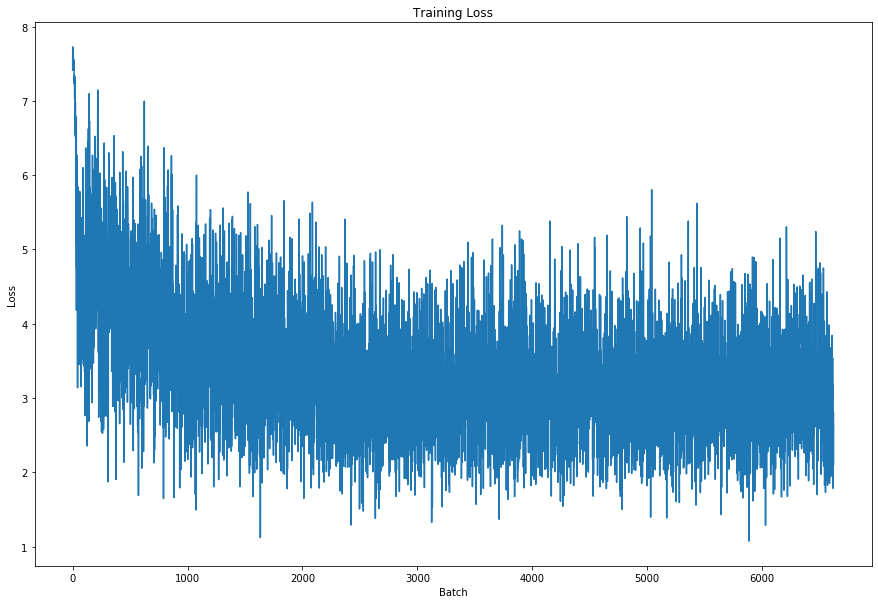

In [0]:
# Graph plotting code X axis is Batch and Y axis is loss
pplot.figure(figsize= (15, 10))
pplot.title("Training Loss")
pplot.xlabel("Batch")
pplot.ylabel("Loss")
pplot.plot(plot_data)
pplot.show()